<a href="https://colab.research.google.com/github/Ehsan1997/ImageSegmentation-UNET-DeepLab-SegNet/blob/master/SegNet_ACV_Assg3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!gdown https://drive.google.com/uc?id=16qPeDiPvB9M-UATZohdg1ssCdaIOnf1- 
!unzip MonuSeg.zip

Downloading...
From: https://drive.google.com/uc?id=16qPeDiPvB9M-UATZohdg1ssCdaIOnf1-
To: /content/MonuSeg.zip
96.1MB [00:03, 29.4MB/s]
Archive:  MonuSeg.zip
  inflating: MonuSeg/Test/TissueImages/TCGA-GL-6846-01A-01-BS1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-AO-A0J2-01A-01-BSA.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-44-2665-01B-06-BS6.tif  
  inflating: MonuSeg/Training/GroundTruth/TCGA-38-6178-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Training/GroundTruth/TCGA-21-5786-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Test/TissueImages/TCGA-A6-6782-01A-01-BS1.tif  
  inflating: MonuSeg/Training/GroundTruth/TCGA-50-5931-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Training/GroundTruth/TCGA-AR-A1AS-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Test/TissueImages/TCGA-HC-7209-01A-01-TS1.tif  
  inflating: MonuSeg/Test/TissueImages/TCGA-IZ-8196-01A-01-BS1.tif  
  inflating: MonuSeg/Training/GroundTruth/TCGA-CH-5767-01Z-00-DX1_bin_mask.png  
  inflating: MonuSeg/Tr

In [0]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from keras import backend as K

Using TensorFlow backend.


In [0]:
# Set some parameters
im_width = 480
im_height = 360
border = 5

In [0]:
ids = next(os.walk("MonuSeg/Training/TissueImages"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

No. of images =  30


In [0]:
X = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids), im_height, im_width, 1), dtype=np.float32)

#### Load the images and masks into arrays

In [0]:
# tqdm is used to display the progress bar
for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
    # Load images
    img = load_img("MonuSeg/Training/TissueImages/"+id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (360, 480, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask_id_ = id_.split('.')[0] + '_bin_mask.png'
    mask = img_to_array(load_img("MonuSeg/Training/GroundTruth/"+mask_id_, grayscale=True))
    mask = resize(mask, (360, 480, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


In [0]:
# Split train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

#### Below code can be used to visualize the images and corresponding masks

Text(0.5, 1.0, 'GroundTruth')

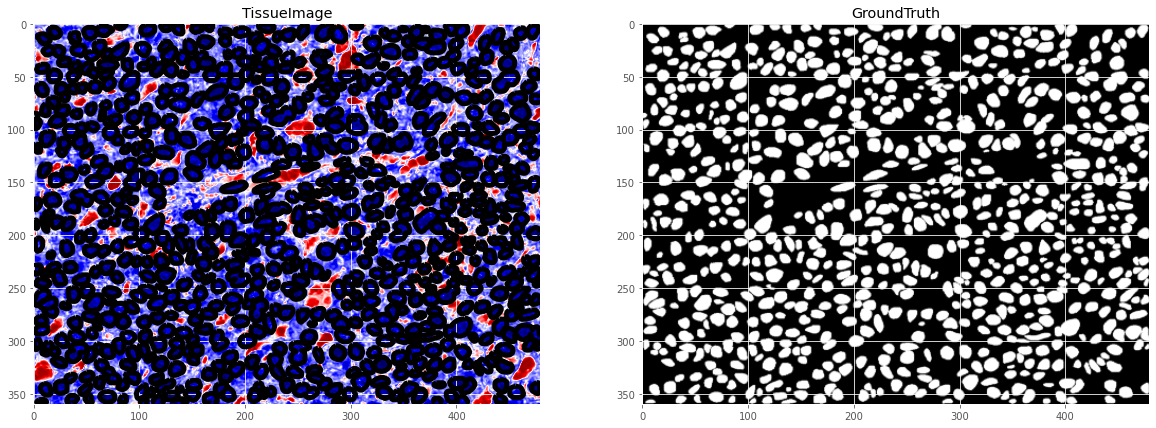

In [0]:
# Visualize any randome image along with the mask
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], cmap = 'seismic', interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('TissueImage')

ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('GroundTruth')

In [0]:
# Define Some metrics
## Dice Score
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())
## F1 Score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [0]:
import keras
from keras.layers import Layer, ZeroPadding2D, Cropping2D
import tensorflow as tf
from tensorflow.keras import backend as K

class MaxPoolingWithIndices(keras.layers.Layer):
    def __init__(self, pool_size,strides,padding='SAME',**kwargs):
        super(MaxPoolingWithIndices, self).__init__(**kwargs)
        self.pool_size=pool_size
        self.strides=strides
        self.padding=padding
        return
    def call(self,x):
        pool_size=self.pool_size
        strides=self.strides
        if isinstance(pool_size,int):
            ps=[1,pool_size,pool_size,1]
        else:
            ps=[1,pool_size[0],pool_size[1],1]
        if isinstance(strides,int):
            st=[1,strides,strides,1]
        else:
            st=[1,strides[0],strides[1],1]
        output1,output2=tf.nn.max_pool_with_argmax(x,ps,st,self.padding)
        return [output1,output2]
    def compute_output_shape(self, input_shape):
        if isinstance(self.pool_size,int):
            output_shape=(input_shape[0],input_shape[1]//self.pool_size,input_shape[2]//self.pool_size,input_shape[3])
        else:
            output_shape=(input_shape[0],input_shape[1]//self.pool_size[0],input_shape[2]//self.pool_size[1],input_shape[3])
        return [output_shape,output_shape]


class UpSamplingWithIndices(Layer):
    def __init__(self, **kwargs):
        super(UpSamplingWithIndices, self).__init__(**kwargs)
        return
    def call(self,x):
        argmax=K.cast(K.flatten(x[1]),'int32')
        max_value=K.flatten(x[0])
        with tf.variable_scope(self.name):
            input_shape=K.shape(x[0])
            batch_size=input_shape[0]
            image_size=input_shape[1]*input_shape[2]*input_shape[3]
            output_shape=[input_shape[0],input_shape[1]*2,input_shape[2]*2,input_shape[3]]
            indices_0=K.flatten(tf.matmul(K.reshape(tf.range(batch_size),(batch_size,1)),K.ones((1,image_size),dtype='int32')))
            indices_1=argmax%(image_size*4)//(output_shape[2]*output_shape[3])
            indices_2=argmax%(output_shape[2]*output_shape[3])//output_shape[3]
            indices_3=argmax%output_shape[3]
            indices=tf.stack([indices_0,indices_1,indices_2,indices_3])
            output=tf.scatter_nd(K.transpose(indices),max_value,output_shape)
            return output
    def compute_output_shape(self, input_shape):
        return input_shape[0][0],input_shape[0][1]*2,input_shape[0][2]*2,input_shape[0][3]

def CompositeConv(inputs,num_layers,num_features):
    output=inputs
    if isinstance(num_features,int):
        for i in range(num_layers):
            output=Conv2D(num_features,(7,7),padding='same')(output)
            output=BatchNormalization(axis=3)(output)
            output=Activation('relu')(output)
        return output
    for i in range(num_layers):
        output=Conv2D(num_features[i],(7,7),padding='same')(output)
        output=BatchNormalization(axis=3)(output)
        output=Activation('relu')(output)
    return output

In [0]:
inputs=Input(shape=(360,480,1))

x = ZeroPadding2D(((12,12),(16,16)))(inputs)

x=CompositeConv(x,2,64)
x,argmax1=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,2,64)
x,argmax2=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,3,64)
x,argmax3=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,3,64)
x,argmax4=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=CompositeConv(x,3,64)
x,argmax5=MaxPoolingWithIndices(pool_size=2,strides=2)(x)

x=UpSamplingWithIndices()([x,argmax5])
x=CompositeConv(x,3,64)

x=UpSamplingWithIndices()([x,argmax4])
x=CompositeConv(x,3,64)

x=UpSamplingWithIndices()([x,argmax3])
x=CompositeConv(x,3,64)

x=UpSamplingWithIndices()([x,argmax2])
x=CompositeConv(x,2,64)

x=UpSamplingWithIndices()([x,argmax1])
x=CompositeConv(x,2,[64,1])

x=Activation('sigmoid')(x)

y=Cropping2D(((12,12),(16,16)))(x)


model=Model(inputs=inputs,outputs=y)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 360, 480, 1)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 384, 512, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 384, 512, 64) 3200        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 384, 512, 64) 256         conv2d_1[0][0]                   
____________________________________________________________________________________________

In [0]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-tgs.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

In [0]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy", dice_coef, f1])
results=model.fit(X_train, y_train, batch_size=1, epochs=8,
                    validation_data=(X_valid, y_valid))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 27 samples, validate on 3 samples
Epoch 1/8
27/27 [==============================] - 24s 902ms/step - loss: 0.7057 - acc: 0.4911 - dice_coef: 0.3634 - f1: 0.3465 - val_loss: 0.7055 - val_acc: 0.5477 - val_dice_coef: 0.3346 - val_f1: 0.4101
Epoch 2/8
27/27 [==============================] - 12s 443ms/step - loss: 0.6685 - acc: 0.5630 - dice_coef: 0.4033 - f1: 0.5718 - val_loss: 0.6894 - val_acc: 0.5656 - val_dice_coef: 0.3249 - val_f1: 0.4750
Epoch 3/8
27/27 [==============================] - 12s 444ms/step - loss: 0.6595 - acc: 0.5727 - dice_coef: 0.4145 - f1: 0.6045 - val_loss: 0.8667 - val_acc: 0.5165 - val_dice_coef: 0.3845 - val_f1: 0.5293
Epoch 4/8
27/27 [==============================] - 12s 445ms/step - loss: 0.6544 - acc: 0.5815 - dice_coef: 0.4220 - f1: 0.6277 - val_loss: 1.2119 - val_acc: 0.4476 - val_dice_coef: 0.4093 - val_f1: 0.5040
Epoch 5/8
27/27 [==================

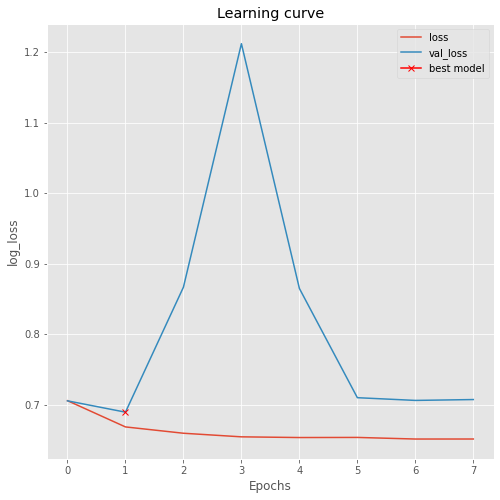

In [0]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();